# Motor and non-motor neuron signature enrichment analysis of 10X Visium spinal cord data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import gseapy as gp

/data/leuven/340/vsc34097/software/conda/envs/DeepSEM/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [6]:
ad = sc.read('/lustre1/project/stg_00002/lcb/nhecker/otf/da_Cruz/submission/spatialnf_multisample/out/data/10X_Visium_mouse_SC_all.10X_Visium_mouse_SC_all.multi_sample.final_output.h5ad')

d = {'Ctrl_1-FUS_R521H':'Ctrl_FUS',
     'Ctrl_2-FUS_R521H':'Ctrl_FUS', 
     'FUS_R521H_1':'FUS',
     'FUS_R521H_2':'FUS'}

ad.obs['cond'] = ad.obs.sample_name.map(d)
ad

Only considering the two last: ['.final_output', '.h5ad'].
Only considering the two last: ['.final_output', '.h5ad'].


AnnData object with n_obs × n_vars = 3357 × 12901
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_name', 'sample_id', 'CellID', 'n_counts', 'n_genes', 'percent_mito', 'batch', 'louvain', 'cond'
    var: 'gene_ids', 'feature_types', 'genome', 'Gene', 'n_cells-SC1_all', 'n_cells-SC2_all', 'n_cells-SC5_all', 'n_cells-SC6_all', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'sample_name_colors', 'sc', 'spatial', 'tsne', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_tsne', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
# Subset to hvg
ad = ad[:, ad.var['highly_variable']]

### Read DE nanostring analysis results

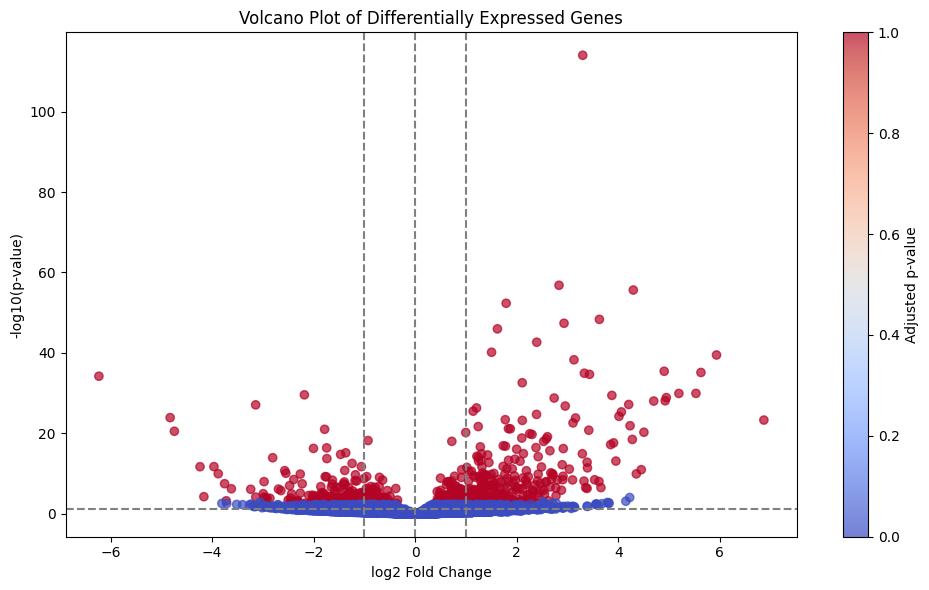

In [9]:
# Read the data from the Excel file
file_path = "/lustre1/project/stg_00002/lcb/gpartel/projects/Visium/OtF-Neuro-pilot/Results_SC_ChATpos_Vs_ChATneg_CTRL_Ordered.xlsx"
df = pd.read_excel(file_path)

# Calculate log10 of p-values and absolute log2 fold change
df['-log10(pvalue)'] = -1 * df['pvalue'].apply(lambda x: math.log10(x))
df['log2FoldChange_abs'] = abs(df['log2FoldChange'])

# Set the significance threshold for p-values (adjust as needed)
significance_threshold = 0.05

# Create the volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(df['log2FoldChange'], df['-log10(pvalue)'],
            c=df['padj'] < significance_threshold, cmap='coolwarm', alpha=0.7)
plt.axhline(-math.log10(0.05), color='gray', linestyle='--', lw=1.5)
plt.axvline(0, color='gray', linestyle='--', lw=1.5)
plt.axvline(1, color='gray', linestyle='--', lw=1.5)
plt.axvline(-1, color='gray', linestyle='--', lw=1.5)

plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot of Differentially Expressed Genes')
plt.colorbar(label='Adjusted p-value')
plt.tight_layout()
plt.show()


In [10]:
# Filter based on logFC and padj
df = df[(df.padj < significance_threshold) & (df.log2FoldChange_abs>1)]

### Extract Chat+ and Chat- marker genes

In [11]:
df_tmp = df[df.log2FoldChange>0].sort_values('log2FoldChange', ascending=False)
Chat_pos_markers = df_tmp['Genes'].to_list()
df_tmp = df[df.log2FoldChange<0].sort_values('log2FoldChange', ascending=True)
Chat_neg_markers = df_tmp['Genes'].to_list()

### Write marker genes on file for GSEA analysis

In [12]:
# Open the file in write mode
with open('/lustre1/project/stg_00002/lcb/gpartel/projects/Visium/OtF-Neuro-pilot/GSEA_gene_sets.gmt', 'w') as f:
    # Write each element of list1 to the file
    f.write('Chat_pos')
    for item in Chat_pos_markers:
        f.write('\t' + str(item))

    # Write each element of list2 to the file
    f.write('\nChat_neg')
    for item in Chat_neg_markers:
        f.write('\t' + str(item))

### Run GSEA enrichment analysis
Find enrichment of Nanostring marker genes in 10X Visiuam data

In [13]:
ad.obs[['cond']]=''
ad.obs.loc[ad.obs.sample_name.str.startswith('Ctrl'), 'cond'] = 'Ctrl'
ad.obs.loc[~ad.obs.sample_name.str.startswith('Ctrl'), 'cond'] = 'Cond'

/local_scratch/tmp-vsc34097/ipykernel_1461974/3051743985.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs[['cond']]=''


In [14]:
ad.obs['cond'] = pd.Categorical(ad.obs['cond'], categories=["Ctrl", "Cond"], ordered=True)
indices = ad.obs.sort_values(['cond']).index
ad = ad[indices,:]

In [15]:
# Run GSEA
results = gp.ssgsea(data=ad.to_df().T, gene_sets='/lustre1/project/stg_00002/lcb/gpartel/projects/Visium/OtF-Neuro-pilot/GSEA_gene_sets.gmt', sample_norm_method='rank', min_size=5)
results.res2d

/data/leuven/340/vsc34097/software/conda/envs/DeepSEM/lib/python3.8/site-packages/gseapy/gsea.py:726: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, ser in df.iteritems():


,TTGTTCAGTGTGCTAC-1___SC6_all-SC6_all,GCTCTAAACCCTGACG-1___SC2_all-SC2_all,ATGCTCAGTGTTGCAT-1___SC6_all-SC6_all,GCTATCGCGGCGCAAC-1___SC2_all-SC2_all,GCTAGTTTCATTGAGG-1___SC2_all-SC2_all,ATGTGCATCCGACGCA-1___SC6_all-SC6_all,ATGTTACGAGCAATAC-1___SC6_all-SC6_all,ATTACTAGCCTCTTGC-1___SC6_all-SC6_all,GCTAATACCGAATGCC-1___SC2_all-SC2_all,GCTAAACCTGAGGTGA-1___SC2_all-SC2_all,...,GTCCGGACCTGAAATT-1___SC2_all-SC2_all,GTCCCGCGACGTTATG-1___SC2_all-SC2_all,GTCAAGCGGACTCGGG-1___SC2_all-SC2_all,GTATCTTTCATAACCA-1___SC2_all-SC2_all,GTATCAAACGTTAGCT-1___SC2_all-SC2_all,GTAGCGGCTATACACT-1___SC2_all-SC2_all,GTAGCCAAACATGGGA-1___SC2_all-SC2_all,GTACGTTTGCCCGTCA-1___SC2_all-SC2_all,GTGAGTGGTACAACGC-1___SC2_all-SC2_all,TCTGAACTCGTACCCG-1___SC2_all-SC2_all
Term|NES,,,,,,,,,,,,,,,,,,,,,
Chat_neg,0.190706,0.216643,-0.380048,0.066546,0.219089,0.111769,0.065263,0.261010,0.044402,-0.272530,...,0.153254,-0.435970,0.230421,0.023413,-0.083670,-0.144628,0.091838,-0.218910,-0.338043,0.267744
Chat_pos,-0.162748,0.105212,-0.104301,0.316054,0.121702,0.090115,0.484506,0.038405,-0.059615,0.206885,...,-0.003281,-0.038028,0.036683,0.154724,0.082007,0.097438,0.042906,0.059267,-0.057057,0.074177


In [16]:
results.res2d = results.res2d.melt(ignore_index=False, var_name='cell_id', value_name='NES')

In [17]:
results.res2d['Term'] = results.res2d.index
results.res2d = results.res2d.set_index('cell_id')
results.res2d

,NES,Term
cell_id,,
TTGTTCAGTGTGCTAC-1___SC6_all-SC6_all,0.190706,Chat_neg
TTGTTCAGTGTGCTAC-1___SC6_all-SC6_all,-0.162748,Chat_pos
GCTCTAAACCCTGACG-1___SC2_all-SC2_all,0.216643,Chat_neg
GCTCTAAACCCTGACG-1___SC2_all-SC2_all,0.105212,Chat_pos
ATGCTCAGTGTTGCAT-1___SC6_all-SC6_all,-0.380048,Chat_neg
...,...,...
GTACGTTTGCCCGTCA-1___SC2_all-SC2_all,0.059267,Chat_pos
GTGAGTGGTACAACGC-1___SC2_all-SC2_all,-0.338043,Chat_neg
GTGAGTGGTACAACGC-1___SC2_all-SC2_all,-0.057057,Chat_pos


In [18]:
ad.obs['Chat_pos_NES']= 0
ad.obs['Chat_neg_NES']= 0

ad.obs.loc[results.res2d[results.res2d.Term=='Chat_pos'].index, 'Chat_pos_NES']= results.res2d[results.res2d.Term=='Chat_pos'].NES.values
ad.obs.loc[results.res2d[results.res2d.Term=='Chat_neg'].index, 'Chat_neg_NES']= results.res2d[results.res2d.Term=='Chat_neg'].NES.values

/local_scratch/tmp-vsc34097/ipykernel_1461974/1977895259.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['Chat_pos_NES']= 0


In [19]:
ad.obs.Chat_pos_NES = ad.obs.Chat_pos_NES.astype(float)
ad.obs.Chat_neg_NES = ad.obs.Chat_neg_NES.astype(float)

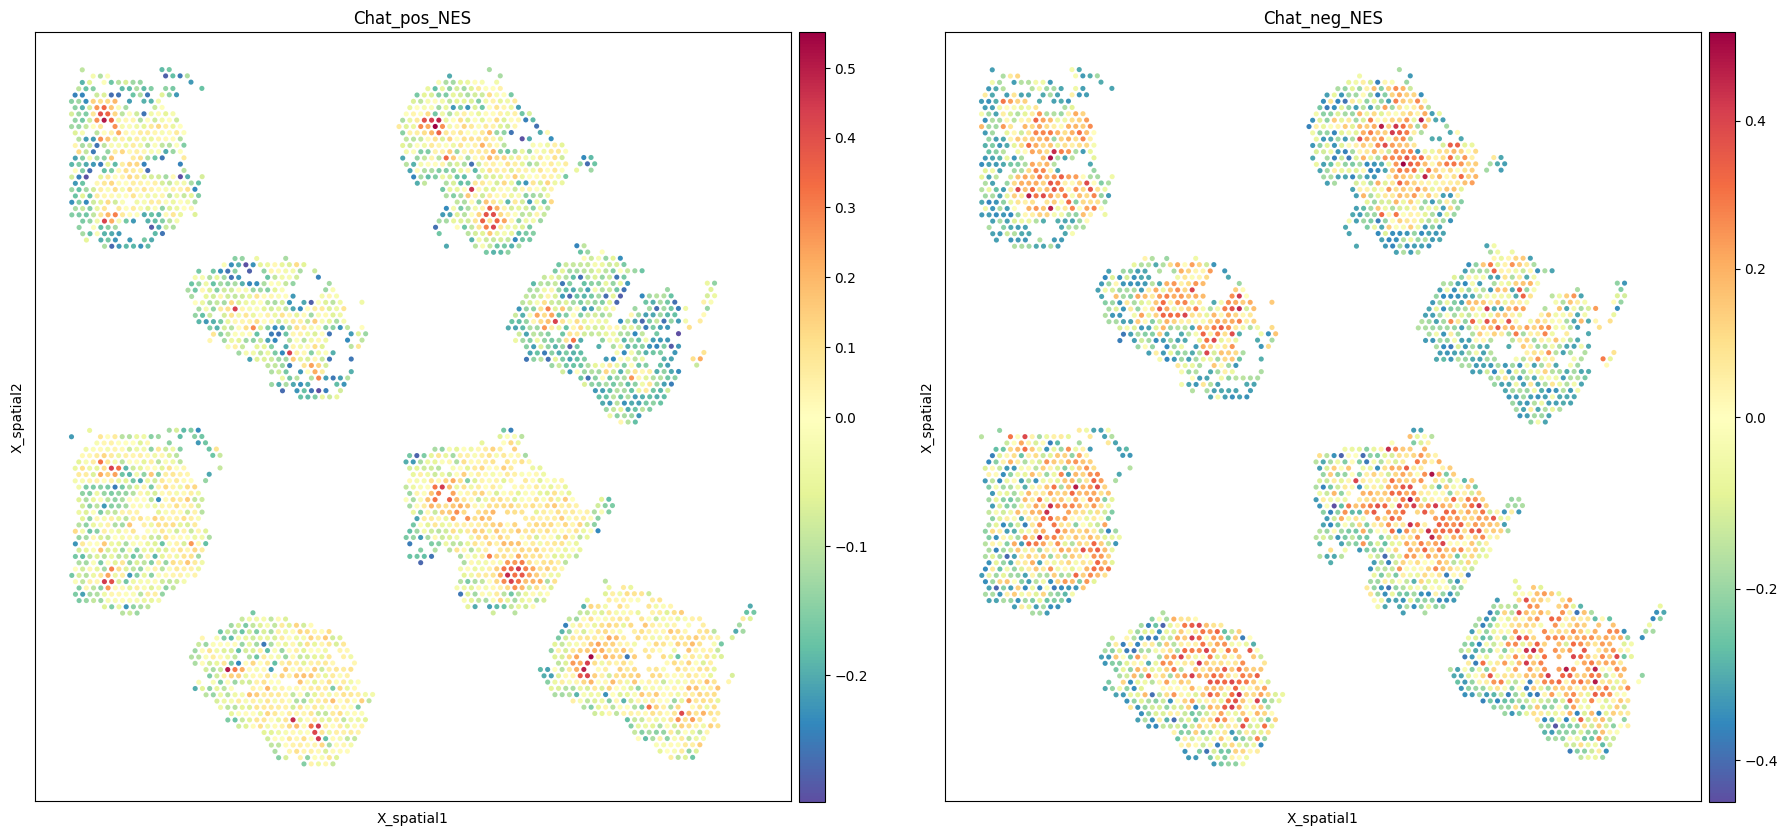

In [33]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10,10)}):
    sc.pl.spatial(ad, basis='X_spatial', spot_size=0.15, color=['Chat_pos_NES', 'Chat_neg_NES'], cmap='Spectral_r', vcenter=0, library_id=None, save='Chat_pos_neg_NES.svg')

### Threshold enrichment scores

In [38]:
th = 0.15
ad_Chat = ad[(ad.obs.Chat_neg_NES>th) | (ad.obs.Chat_pos_NES>th)].raw.to_adata()
ad_Chat.X = ad_Chat.X.todense()

In [39]:
ad.obs['Chat'] = 'Other'
ad.obs.loc[ad.obs['Chat_neg_NES']>th, 'Chat']= 'Chat -' # Set to 1 coeff to test
ad.obs.loc[ad.obs['Chat_pos_NES']>th, 'Chat']= 'Chat +' # Set to 1 coeff to test
ad.obs.Chat = pd.Categorical(ad.obs.Chat)

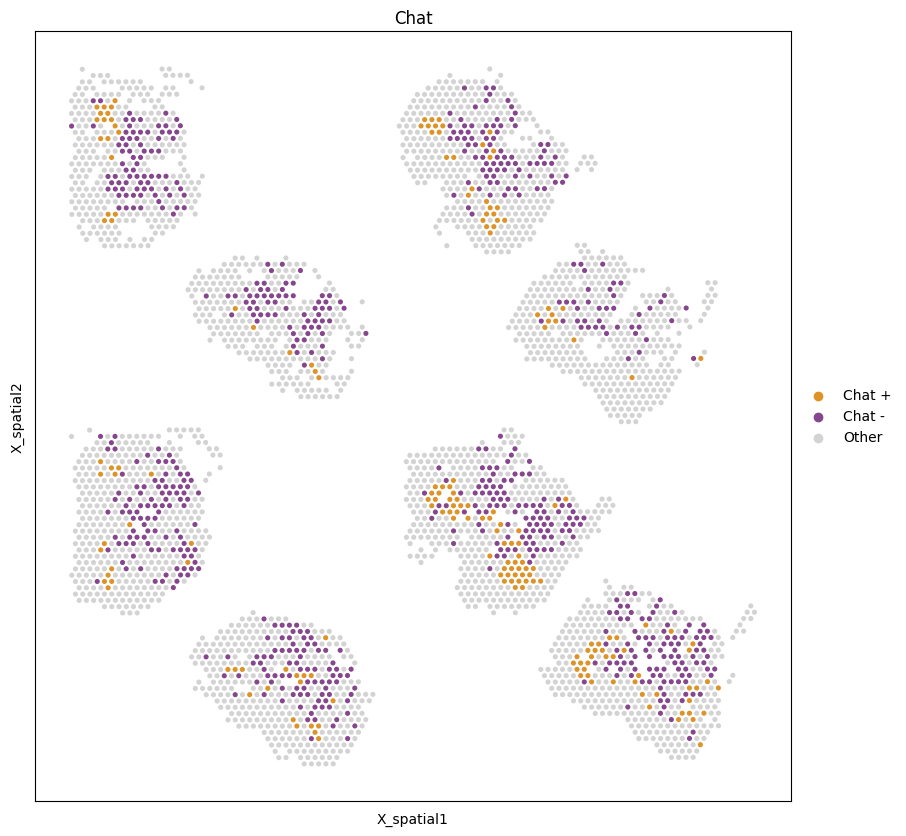

In [40]:
# from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10,10)}):
#     sc.pl.spatial(ad_Chat[(ad_Chat.obs.Chat_pos_NES>th)], basis='X_spatial', spot_size=0.2, color)
#     sc.pl.spatial(ad_Chat[(ad_Chat.obs.Chat_neg_NES>th)], basis='X_spatial', spot_size=0.2)    
    sc.pl.spatial(ad, basis='X_spatial', spot_size=0.15, color='Chat', palette=['#dd9327ff','#86468dff', 'lightgray'], library_id=None, save='Chat_pos_neg.svg')


In [42]:
markers = ['Eif1','Eif4a1','Eif4g3','Rpl13a','Rpl17','Rpl35a','Rps15a','Rps17','Rps2','Rpl24','Rps4x','Eif5a','Dohh','Dhps']

In [69]:
ad_Chat_pos = ad_Chat[(ad_Chat.obs.Chat=='Chat +')].copy()
df_Chat_pos = ad_Chat_pos.to_df().loc[:, markers]

In [79]:
df_Chat_pos['cond'] = ad_Chat_pos.obs.cond.values

df_0 = df_Chat_pos[df_Chat_pos.cond=='Ctrl']
df_1 = df_Chat_pos[df_Chat_pos.cond=='Cond']
df_0 = df_0.drop('cond', axis=1).melt()
df_1 = df_1.drop('cond', axis=1).melt()
df_0['cond'] = 'Ctrl'
df_1['cond'] = 'FUS'
df = pd.concat([df_0,df_1])

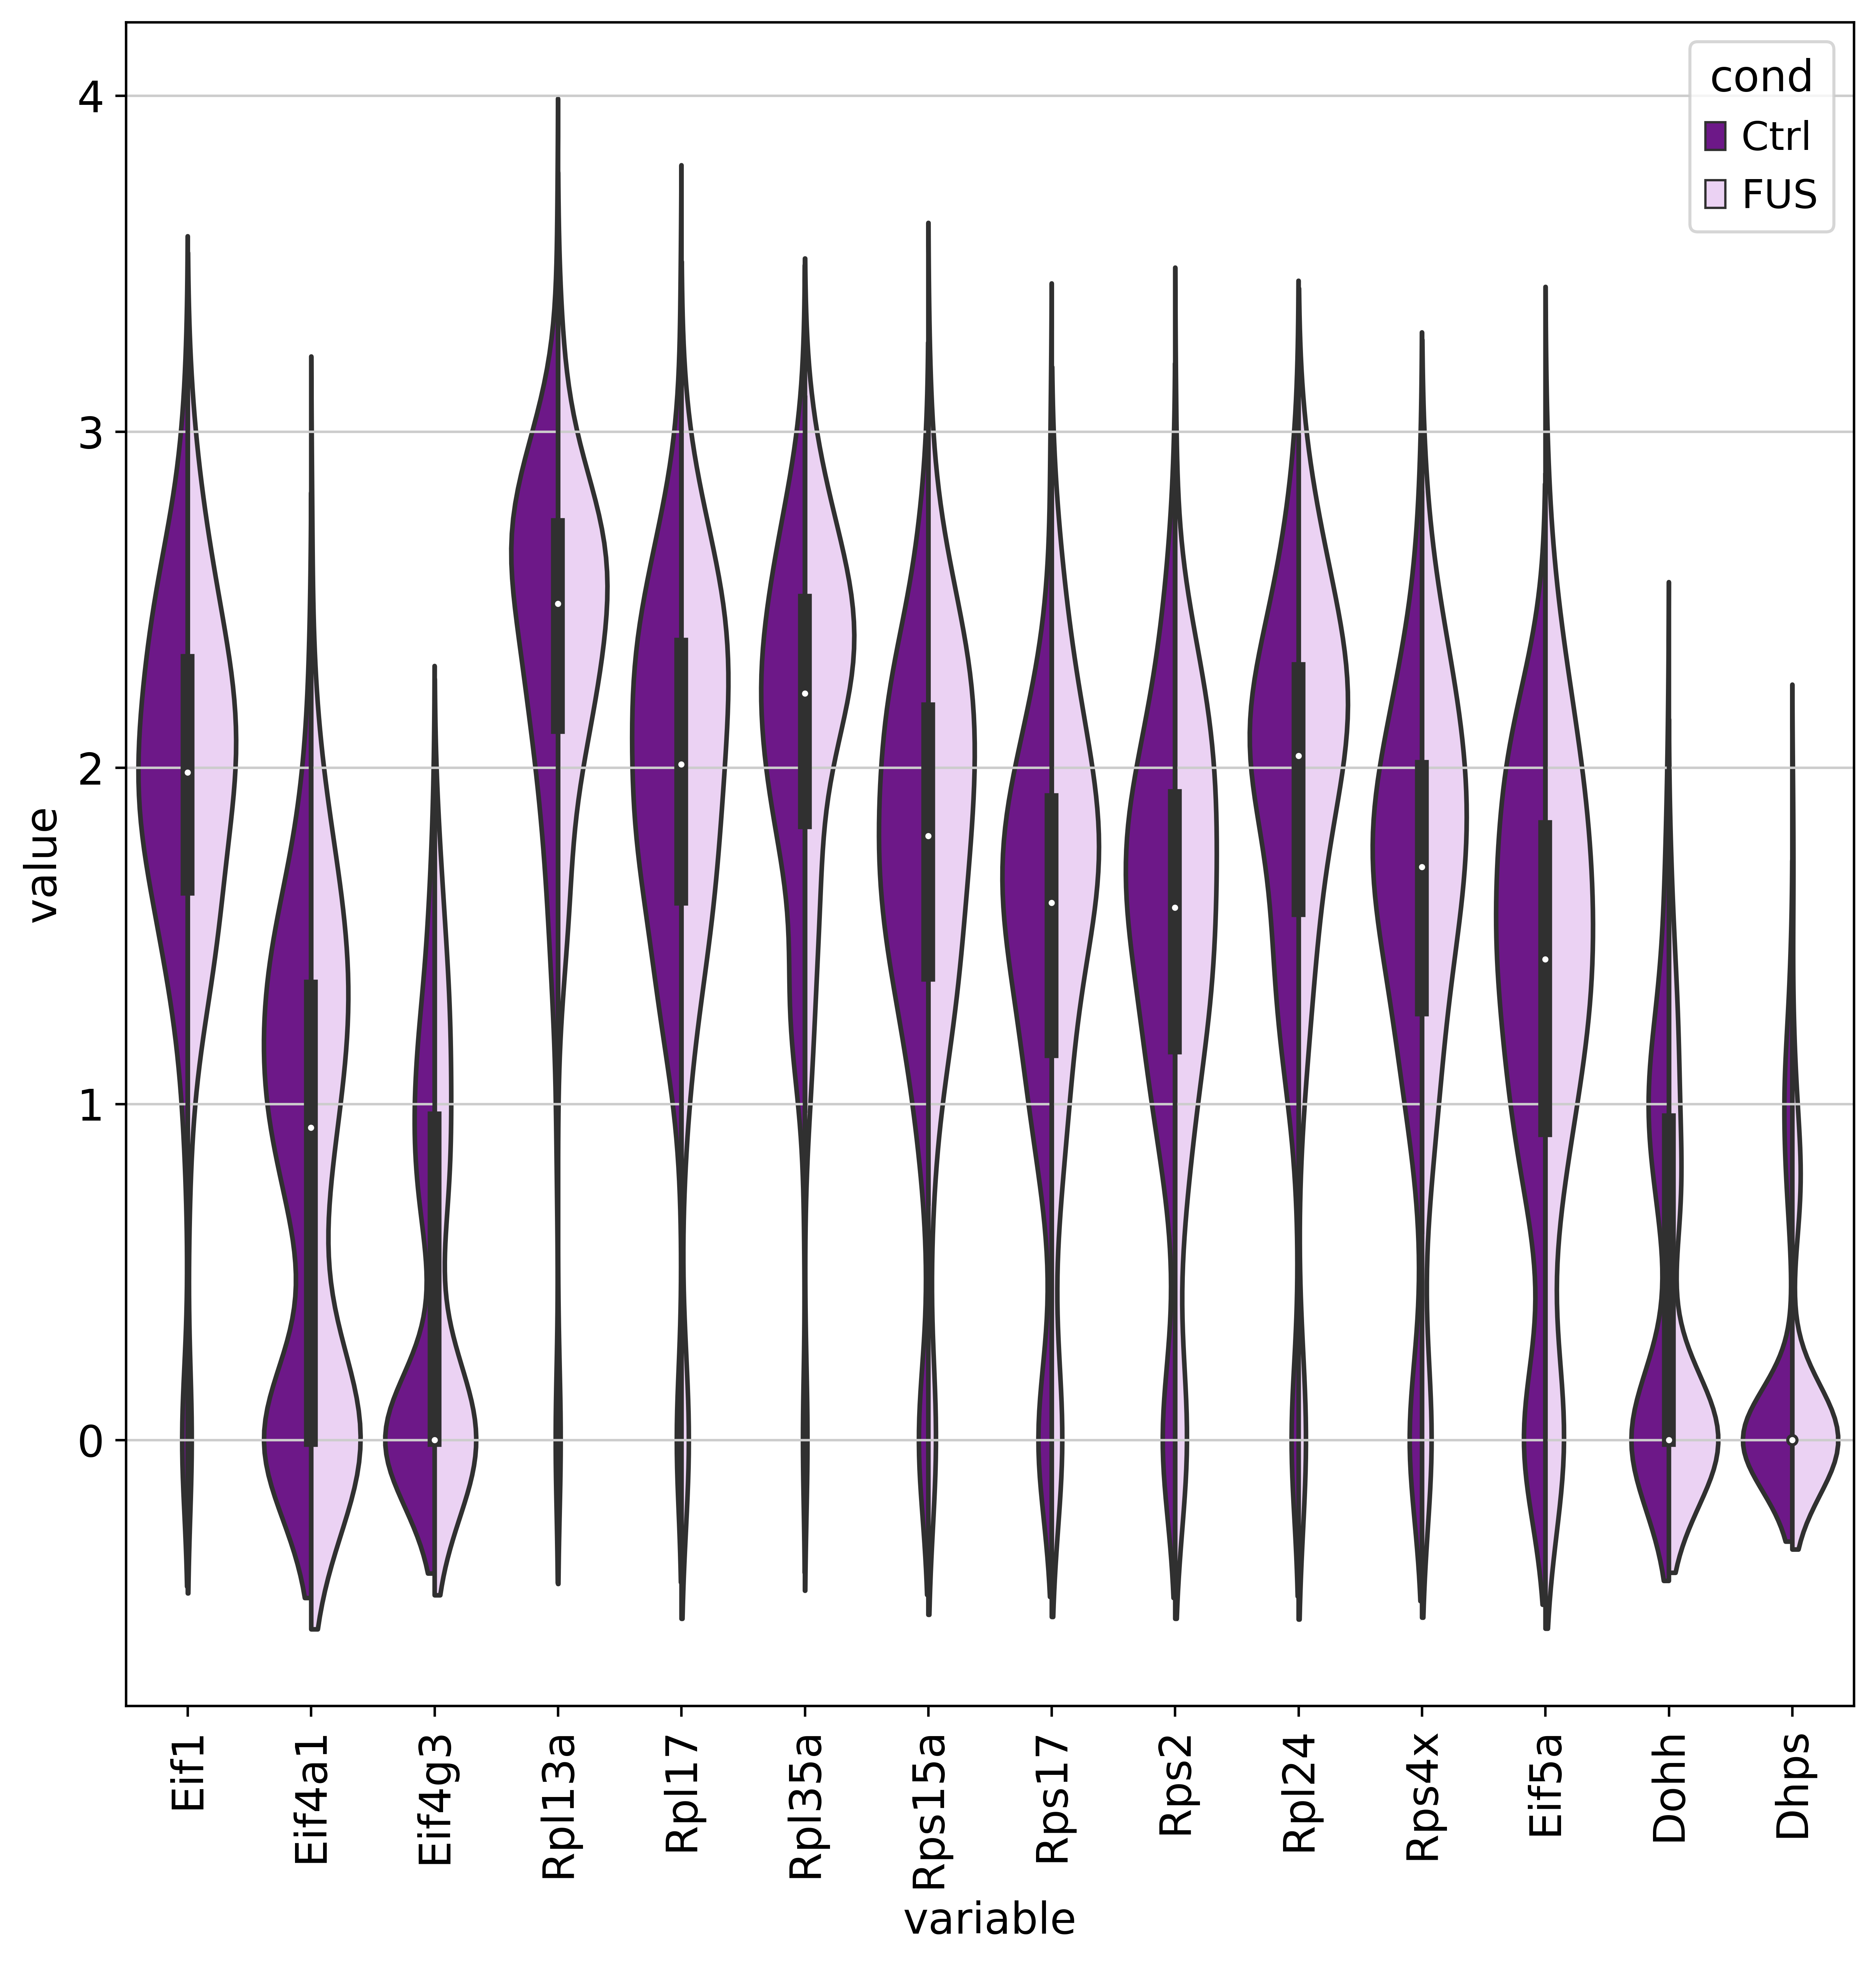

In [81]:
import seaborn as sns
sc.set_figure_params(figsize=(10,10), dpi=300)
ax = sns.violinplot(data=df, x = 'variable', y='value', hue='cond', split=True, palette=['#76069A', '#EECCF9'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);